<a href="https://colab.research.google.com/github/VikaBilyk/mss/blob/main/lab2/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(140, 188)


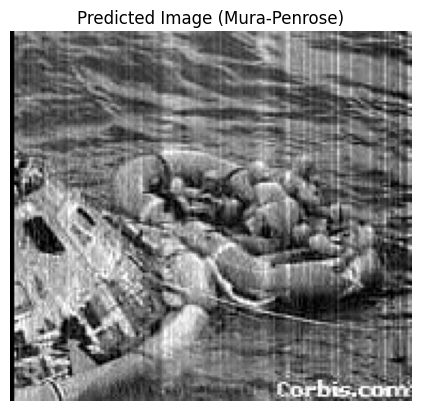

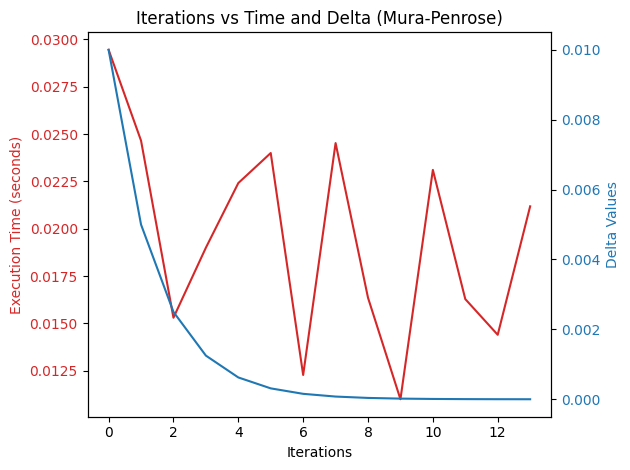

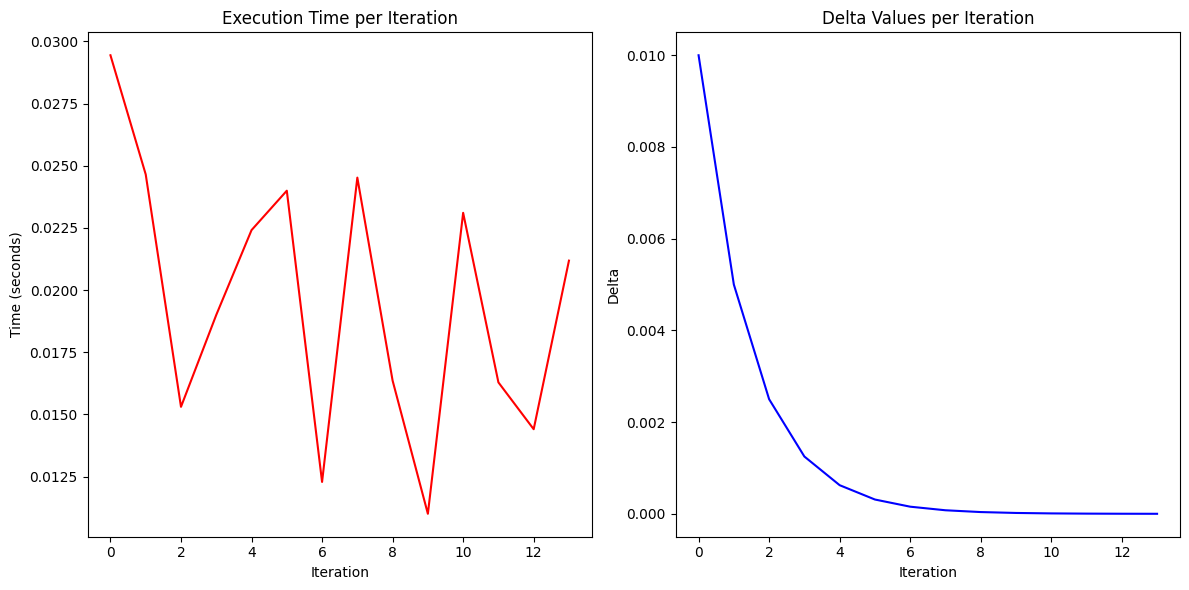


--- Efficiency Report for Mura-Penrose ---
Total Iterations: 14
Delta Value at Last Iteration: 1.220703125e-06
Total Time Taken: 0.27395 seconds
Condition AA+A = A: Satisfied
Condition A+AA+ = A+: Not satisfied
Condition AA+ is symmetric: Satisfied
Condition A+A is symmetric: Satisfied


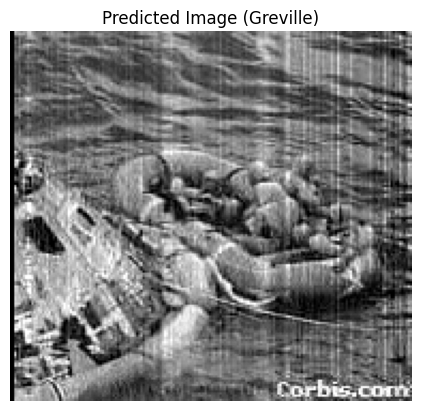

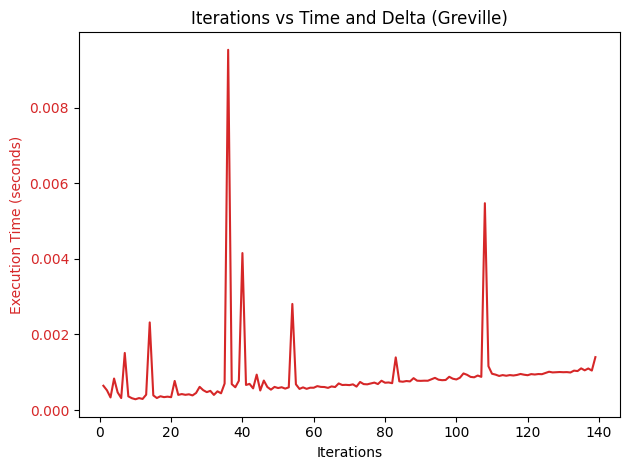


--- Efficiency Report for Greville ---
Total Iterations: 139
Total Time Taken: 0.12133 seconds
Condition AA+A = A: Not satisfied
Condition A+AA+ = A+: Not satisfied
Condition AA+ is symmetric: Not satisfied
Condition A+A is symmetric: Not satisfied


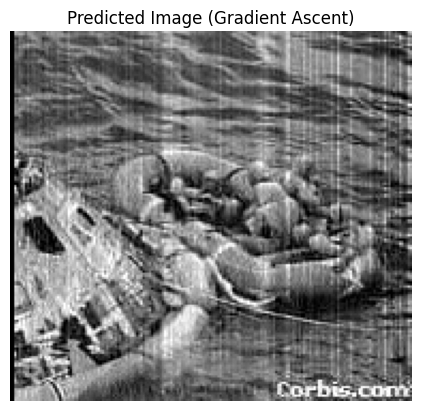

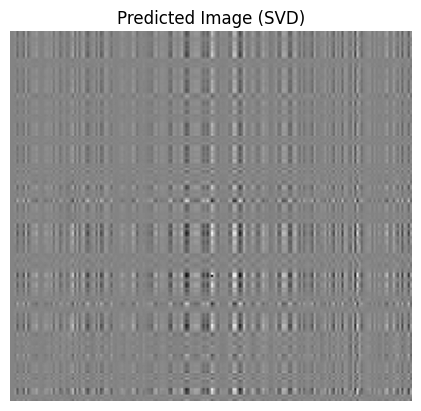

In [30]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time

def muraPenrousa(aMatrix, delta_start, epsilon_threshold=1e-5, max_iter=1000):
    E = np.eye(aMatrix.shape[0])

    #Задається початкове значення delta
    delta = delta_start

    execution_times, delta_values, iteration_numbers = [], [], []

    for i in range(max_iter):
        start_time = time.time()

        #Розраховується початкове наближення
        aPseudoInverse = aMatrix.T @ np.linalg.inv(aMatrix @ aMatrix.T + delta**2 * E)

        #На кроці k нове значення дельта_k
        delta_half = delta / 2

        execution_times.append(time.time() - start_time) #поточний час виконання кожної ітерації
        delta_values.append(delta) # поточна дельта на кожній ітерації
        iteration_numbers.append(i) # поточний номер ітерації

        #Розрахунок наближення псевдооберненої матриці А на кроці k
        if np.linalg.norm(aPseudoInverse - aMatrix.T @ np.linalg.inv(aMatrix @ aMatrix.T + delta_half**2 * E)) < epsilon_threshold:
            break

        delta = delta_half

    return aPseudoInverse, iteration_numbers, execution_times, delta_values


def greville_algorithm(aMatrix, epsilon=1e-5):

    first_row = aMatrix[0]
    denominator = first_row.T @ first_row

    # Ініціалізація псевдооберненої матриці
    aPseudoInverse = np.vstack(first_row / denominator if denominator != 0 else first_row)

    current_matrix = np.array([first_row])
    num_rows = aMatrix.shape[0]

    # Списки для зберігання результатів
    iteration_time_list = []  # Час на кожну ітерацію Греввіля
    iteration_index_list = []  # Номери ітерацій

    for j in range(1, num_rows):
        start_time = time.time()  # Початок часу для кожної ітерації

        current_row = aMatrix[j].reshape(-1, 1)
        E = np.identity(current_matrix.shape[1])
        Z_A = E - aPseudoInverse @ current_matrix

        current_matrix = np.vstack([current_matrix, aMatrix[j]])
        # Обчислення знаменника для оновлення
        denominator = np.dot(current_row.T, (Z_A @ current_row))[0, 0]

        if np.abs(denominator) < epsilon:
            correction_matrix = aPseudoInverse @ aPseudoInverse.T
            denominator = 1 + np.dot(current_row.T, (correction_matrix @ current_row))
            aPseudoInverse = np.hstack([
                aPseudoInverse - np.dot(Z_A, np.dot(current_row, (current_row.T @ aPseudoInverse))) / denominator,
                np.dot(correction_matrix, current_row) / denominator
            ])
        else:
            aPseudoInverse = np.hstack([
                aPseudoInverse - np.dot(Z_A, np.dot(current_row, (current_row.T @ aPseudoInverse))) / denominator,
                np.dot(Z_A, current_row) / denominator
            ])

        # Зберігання часу і номеру ітерації
        iteration_time_list.append(time.time() - start_time)
        iteration_index_list.append(j)

    return {
        "pseudo_inverse": aPseudoInverse,
        "iteration_indices": iteration_index_list,
        "iteration_times": iteration_time_list,
        "final_denominator": denominator  # Додаємо останнє значення знаменника
    }

def gradient_ascent_method(aMatrix, delta_start, stepCoef=0.001, epsilon=1e-5, max_iter=1000, min_delta=1e-6, max_delta=1000):
    E = np.eye(aMatrix.shape[0])
    delta = delta_start
    start_stepCoef = stepCoef
    pseudo_inverse_history = []

    iteration_times, delta_values, iteration_indices = [], [], []

    for iter_index in range(max_iter):
        start_time = time.time()

        aPseudoInverse = aMatrix.T @ np.linalg.inv(aMatrix @ aMatrix.T + delta**2 * E)
        # grad використовується для оновлення delta в кожній ітерації градієнтного підйому
        grad = delta * 2 * np.trace(aPseudoInverse.T @ aPseudoInverse) # 2*delta ми використовуєм для масштабування

        # Експоненційне зменшення кроку
        # Швидкість з якою змінюється delta на кожній ітерації алгоритму
        start_stepCoef = stepCoef * np.exp(-0.01 * iter_index) # швидкість змінюється експоненціально,
        #тобто спочатку швидкість оновлення буде великою, при наближені до остаточного рішення - швидкість буде зменшуватись

        # Оновлення delta
        # Зменшуємо його на величину пропорційну градієнту, що дозволяє алгоритму шукати оптимальне значення.
        new_delta = delta - start_stepCoef * grad
        # Ставимо межі дельта,
        # Якщо дельта виходить за межі, ми його прирівнюємо до найбільш наближеної границі
        new_delta = np.clip(new_delta, min_delta, max_delta)

        iteration_times.append(time.time() - start_time)
        delta_values.append(delta)
        iteration_indices.append(iter_index)

        pseudo_inverse_history.append(aPseudoInverse.copy())  # Збереження проміжних матриць

        if abs(new_delta - delta) < epsilon:
            break

        delta = new_delta

    return aPseudoInverse, iteration_indices, iteration_times, delta_values, pseudo_inverse_history


def customSVD(matrix, num_singular_values=None, epsilon=1e-10, max_iterations=1000):
    num_rows, num_cols = matrix.shape
    num_singular_values = min(num_rows, num_cols) if num_singular_values is None else min(num_singular_values, num_rows, num_cols)

    if num_rows >= num_cols:
        left_singular_vectors = np.zeros((num_rows, num_singular_values))
        singular_values = np.zeros(num_singular_values)
        right_singular_vectors = np.zeros((num_cols, num_singular_values))

        for i in range(num_singular_values):
            right_vector = np.random.rand(num_cols)
            right_vector /= np.linalg.norm(right_vector)

            for _ in range(max_iterations):
                left_vector = matrix @ right_vector
                singular_value = np.linalg.norm(left_vector)

                if singular_value < epsilon:
                    break

                left_vector /= singular_value
                right_vector = matrix.T @ left_vector
                right_vector /= np.linalg.norm(right_vector)

            left_singular_vectors[:, i] = left_vector
            singular_values[i] = singular_value
            right_singular_vectors[:, i] = right_vector

            matrix -= singular_value * np.outer(left_vector, right_vector)
    else:
        right_singular_vectors = np.zeros((num_cols, num_singular_values))
        singular_values = np.zeros(num_singular_values)
        left_singular_vectors = np.zeros((num_rows, num_singular_values))

        for i in range(num_singular_values):
            left_vector = np.random.rand(num_rows)
            left_vector /= np.linalg.norm(left_vector)

            for _ in range(max_iterations):
                right_vector = matrix.T @ left_vector
                singular_value = np.linalg.norm(right_vector)

                if singular_value < epsilon:
                    break

                right_vector /= singular_value
                left_vector = matrix @ right_vector
                left_vector /= np.linalg.norm(left_vector)

            right_singular_vectors[:, i] = right_vector
            singular_values[i] = singular_value
            left_singular_vectors[:, i] = left_vector

            matrix -= singular_value * np.outer(left_vector, right_vector)

    return left_singular_vectors, singular_values, right_singular_vectors.T

def pseudoInverseMatrix_SVD(matrix, eps=1e-6):
    left_singular_vectors, singular_values, right_singular_vectors_transposed = customSVD(matrix)

    rank_of_matrix = np.sum(singular_values > eps)

    singular_values_inverse = np.zeros_like(singular_values)
    singular_values_inverse[:rank_of_matrix] = 1 / singular_values[:rank_of_matrix]

    pseudo_inverse_matrix = (right_singular_vectors_transposed.T @ np.diag(singular_values_inverse) @ left_singular_vectors.T)

    return pseudo_inverse_matrix


# Нормалізуємо матрицю, щоб уникнути проблем з масштабуванням під час обчислень,
# таких як інверсія матриць та неточні числові обчислення
# Приводимо значення елементів матриці в діапазон від 0 до 1
def normalize_image(image_matrix):
    min_val = np.min(image_matrix)
    max_val = np.max(image_matrix)

    # Уникнемо поділу на нуль
    if max_val - min_val == 0:
        return np.zeros_like(image_matrix, dtype=np.uint8)

    # Масштабуємо в діапазон [0, 255]
    normalized_image = (image_matrix - min_val) / (max_val - min_val) * 255
    return normalized_image.astype(np.uint8)



def show_image(aMatrix, img_title):
    # Перетворення значень у діапазон 0-255
    normalized_img = np.clip(aMatrix * 255, 0, 255).astype(np.uint8)
    img = Image.fromarray(normalized_img)
    plt.imshow(img, cmap='gray')
    plt.title(img_title)
    plt.axis('off')
    plt.show()


def plot_time_and_iterations(iter_indices, exec_times, delta_vals=None, method_label="Method"):
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Execution Time (seconds)', color='tab:red')
    ax1.plot(iter_indices, exec_times, color='tab:red', label="Execution Time")
    ax1.tick_params(axis='y', labelcolor='tab:red')

    if delta_vals is not None:
        ax2 = ax1.twinx()
        ax2.set_ylabel('Delta Values', color='tab:blue')
        ax2.plot(iter_indices, delta_vals, color='tab:blue', label="Delta Values")
        ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.title(f'Iterations vs Time and Delta ({method_label})')
    fig.tight_layout()
    plt.show()

def performance_summary(exec_times, delta_vals):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].plot(range(len(exec_times)), exec_times, color='red')
    axes[0].set_title('Execution Time per Iteration')
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Time (seconds)')

    if delta_vals:
        axes[1].plot(range(len(delta_vals)), delta_vals, color='blue')
        axes[1].set_title('Delta Values per Iteration')
        axes[1].set_xlabel('Iteration')
        axes[1].set_ylabel('Delta')

    plt.tight_layout()
    plt.show()

def efficiency_report(iter_indices, exec_times, delta_vals=None, method_label="Method"):
    print(f"\n--- Efficiency Report for {method_label} ---")
    print(f"Total Iterations: {len(iter_indices)}")
    if delta_vals:
        print(f"Delta Value at Last Iteration: {delta_vals[-1]}")
    print(f"Total Time Taken: {sum(exec_times):.5f} seconds")

def validate_pseudo_inverse_properties(A, A_pseudo):
    conditions = [
        (np.allclose(A @ A_pseudo @ A, A), "Condition AA+A = A"),
        (np.allclose(A_pseudo @ A @ A_pseudo, A_pseudo), "Condition A+AA+ = A+"),
        (np.allclose(A @ A_pseudo, (A @ A_pseudo).T), "Condition AA+ is symmetric"),
        (np.allclose(A_pseudo @ A, (A_pseudo @ A).T), "Condition A+A is symmetric")
    ]

    for condition, desc in conditions:
        print(f"{desc}: {'Satisfied' if condition else 'Not satisfied'}")

    return [condition for condition, _ in conditions]


def main_execution():
    # Load the images
    input_image = Image.open("x1.bmp")
    output_image = Image.open("y2.bmp")

    # Convert images to matrices and normalize
    input_matrix = normalize_matrix_with_scaler(np.array(input_image, dtype=float))
    output_matrix = normalize_matrix_with_scaler(np.array(output_image, dtype=float))
    print(input_matrix.shape)

    # Mura-Penrose Method
    pseudo_inv_mura, iter_counts, iter_times, delta_vals = muraPenrousa(input_matrix, 0.01)
    A_mura = output_matrix @ pseudo_inv_mura
    predicted_mura = A_mura @ input_matrix
    show_image(predicted_mura, img_title='Predicted Image (Mura-Penrose)')
    print()

    plot_time_and_iterations(iter_counts, iter_times, delta_vals, "Mura-Penrose")
    performance_summary(iter_times, delta_vals)
    efficiency_report(iter_counts, iter_times, delta_vals, "Mura-Penrose")
    validate_pseudo_inverse_properties(input_matrix, pseudo_inv_mura)

    # Greville Method
    results = greville_algorithm(input_matrix, 0.01)
    pseudo_inv_greville = results["pseudo_inverse"]
    iter_greville = results["iteration_indices"]
    iter_times_greville = results["iteration_times"]

    A_greville = output_matrix @ pseudo_inv_greville
    predicted_greville = A_greville @ input_matrix
    show_image(predicted_greville, img_title='Predicted Image (Greville)')


    plot_time_and_iterations(iter_greville, iter_times_greville, method_label="Greville")
    # performance_summary(iter_times_greville, [])
    efficiency_report(iter_greville, iter_times_greville, method_label="Greville")
    validate_pseudo_inverse_properties(input_matrix, pseudo_inv_greville)

    # Gradient Descent Method
    pseudo_inv_gradient, iter_grad, iter_times_grad, delta_vals_grad, pseudo_inverse_history = gradient_ascent_method(input_matrix, 0.01)

    # Використовуємо останню псевдообернену матрицю для розрахунку A_gradient
    A_gradient = output_matrix @ pseudo_inv_gradient

    # Передбачаємо зображення
    predicted_gradient = A_gradient @ input_matrix

    # Виводимо передбачене зображення
    show_image(predicted_gradient, img_title='Predicted Image (Gradient Ascent)')


    # plot_time_and_iterations(iter_grad, iter_times_grad, delta_vals_grad, "Gradient Descent")
    # performance_summary(iter_times_grad, delta_vals_grad)
    # efficiency_report(iter_grad, iter_times_grad, delta_vals_grad, "Gradient Descent")
    # validate_pseudo_inverse_properties(input_matrix, pseudo_inv_gradient)

    # SVD Method
    pseudo_inv_svd = pseudoInverseMatrix_SVD(input_matrix)

    A_svd = output_matrix @ pseudo_inv_svd
    predicted_svd = A_svd @ input_matrix

    # Normalize the predicted image
    predicted_svd_normalized = normalize_image(predicted_svd)

    # Display the predicted image from SVD
    show_image(predicted_svd, img_title='Predicted Image (SVD)')


if __name__ == "__main__":
    main_execution()
